In [1]:
import scipy.stats as stats
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
!pip3 install pysindy
import pysindy as ps
!pip3 install pyflo
from pyflo import system
from pyflo.nrcs import hydrology

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.1/113.1 KB 2.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyflo: filename=pyflo-0.3.3-py3-none-any.whl size=72015 sha256=c43f8c1e332ad8938c79a00dd3692f1b547d0fdcd7466e9628550947656ee143
  Stored in directory: /root/.cache/pip/wheels/ca/17/c3/141243b08924d94c2cebf4d8d2df5977fc71a377a37c89c03c
Successfully built pyflo


# optimal input transformation for mallets creek hydrograph

can't use built in methods from other people because I'm transforming the input, not just fitting the discharge

(could do that if I'm categorizing the rainfall as impulsive, but I don't think that's a good approximation)

<ipython-input-2-490a520ee0e4>:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(rainfall['period'], rainfall['average'])


Text(0.5, 1.0, 'flow')

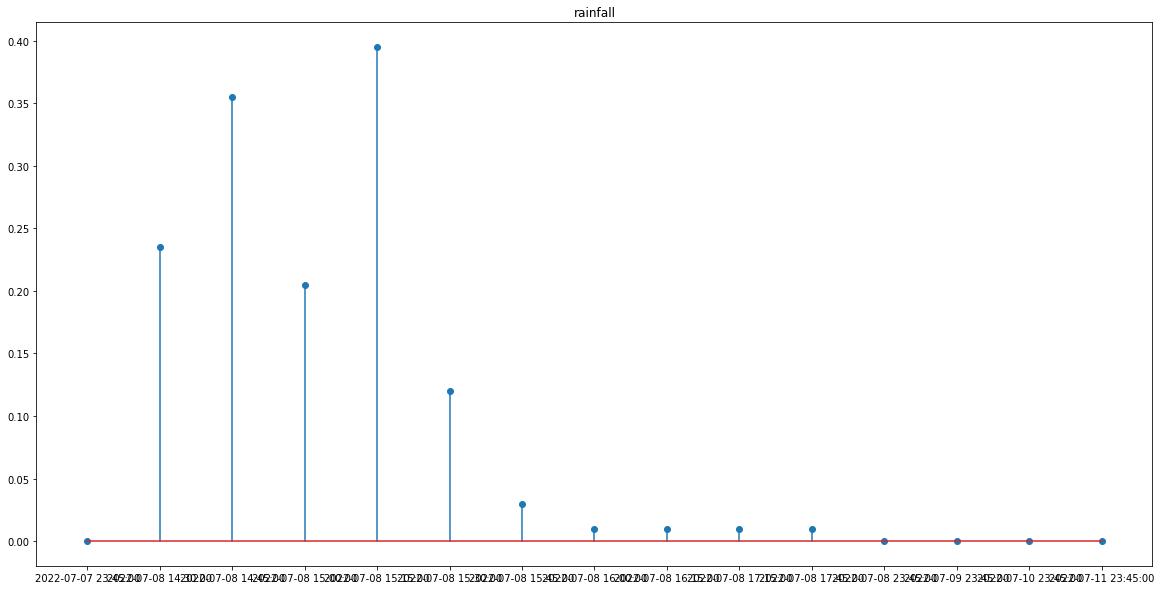

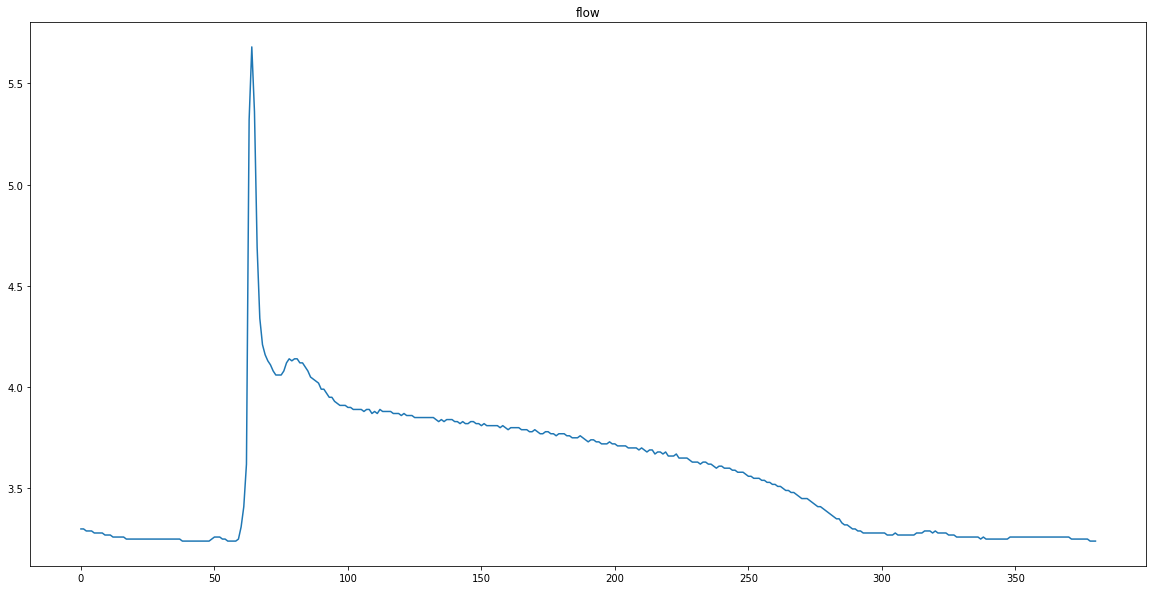

In [2]:
rainfall = pd.read_csv('/content/drive/MyDrive/PhD Admin and Notes/paper1/ann-arbor-rain-gages.csv')
#print(rainfall)
request_string = 'https://nwis.waterservices.usgs.gov/nwis/iv/?sites=04174518&parameterCd=00065&startDT=2022-07-07T00:00:00.000-04:00&endDT=2022-07-12T00:00:00.000-04:00&siteStatus=all&format=rdb'

meta = pd.read_csv(request_string, skiprows=14,nrows=10,sep='\t')
site_name = meta.columns[0][5:]
data = pd.read_csv(request_string,header = [26], skiprows=[27],sep='\t').fillna(method='bfill')
data = data[data['datetime'] >= rainfall['period'][0]]
data = data.reset_index(drop=True)


# chop off first little bit
#data = data[50:]
#data.reset_index(inplace=True,drop=True)
#data = data[:250]
#data.reset_index(inplace=True,drop=True)
#print(data.datetime)
plt.figure(figsize=(20,10))
plt.stem(rainfall['period'], rainfall['average'])
plt.title("rainfall")

plt.figure(figsize=(20,10))
plt.plot(data['281748_00065'])
plt.title("flow")

# data be gotten



/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-3-adaf2c5c3c53>:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  l2 = ax2.stem(data.rainfall,linefmt='k',markerfmt=' ',basefmt=' ',label='rainfall')


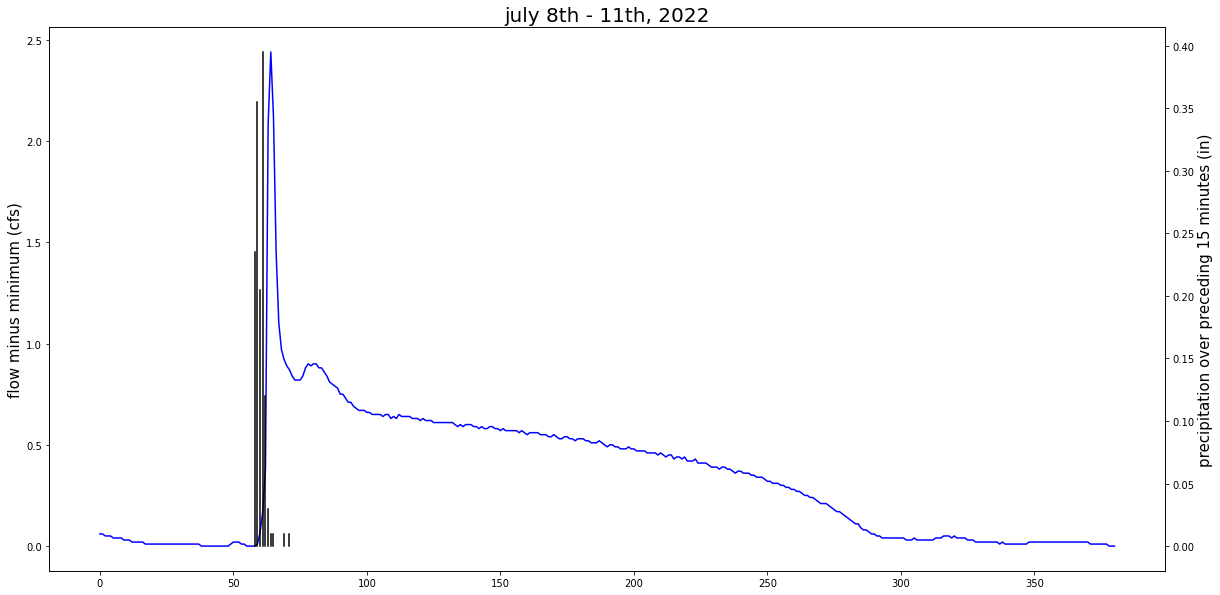

In [3]:
# line up data
#print(data.datetime)
#print(rainfall.period)
data['rainfall'] = np.zeros(len(data.datetime))

for rainfall_idx in range(0,len(rainfall.period)):
  #print(pd.to_datetime(rainfall.period[rainfall_idx]))
  match_index = np.where(pd.to_datetime(data.datetime) == pd.to_datetime(rainfall.period[rainfall_idx]))
  #print(match_index[0])
  data.rainfall.iloc[match_index] = rainfall.average.iloc[rainfall_idx]
  #print(data.rainfall[match_index])

data['flow'] = data['281748_00065'] - min(data['281748_00065'])

fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()
l1 = ax1.plot(data.flow,'b',label='flow minus minimum')
l2 = ax2.stem(data.rainfall,linefmt='k',markerfmt=' ',basefmt=' ',label='rainfall')
ax1.set_ylabel("flow minus minimum (cfs)",fontsize=15)
ax2.set_ylabel("precipitation over preceding 15 minutes (in)",fontsize=15)
plt.title("july 8th - 11th, 2022",fontsize=20)

data.set_index(pd.DatetimeIndex(data['datetime']),inplace=True)

                     rainfall  flow
datetime                           
2022-07-08 00:00:00       0.0  0.06
2022-07-08 00:01:00       NaN   NaN
2022-07-08 00:02:00       NaN   NaN
2022-07-08 00:03:00       NaN   NaN
2022-07-08 00:04:00       NaN   NaN
...                       ...   ...
2022-07-11 22:56:00       NaN   NaN
2022-07-11 22:57:00       NaN   NaN
2022-07-11 22:58:00       NaN   NaN
2022-07-11 22:59:00       NaN   NaN
2022-07-11 23:00:00       0.0  0.00

[5701 rows x 2 columns]
                     rainfall  flow
datetime                           
2022-07-08 00:00:00       0.0  0.06
2022-07-08 00:01:00       0.0  0.06
2022-07-08 00:02:00       0.0  0.06
2022-07-08 00:03:00       0.0  0.06
2022-07-08 00:04:00       0.0  0.06
...                       ...   ...
2022-07-11 22:56:00       0.0  0.00
2022-07-11 22:57:00       0.0  0.00
2022-07-11 22:58:00       0.0  0.00
2022-07-11 22:59:00       0.0  0.00
2022-07-11 23:00:00       0.0  0.00

[5701 rows x 2 columns]


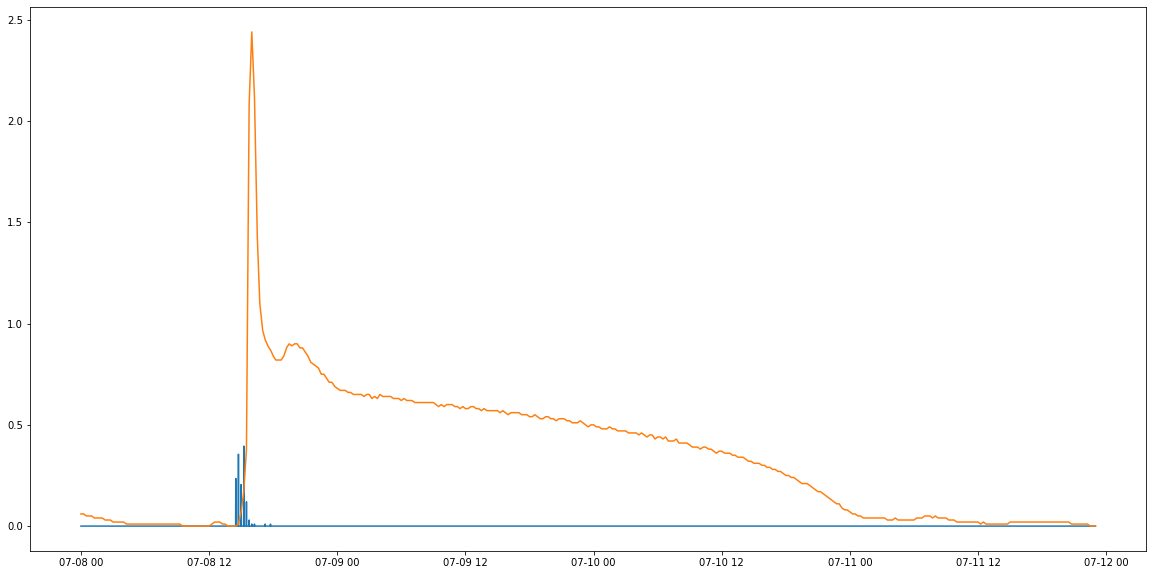

In [4]:
# make time series every minute

rainfall_series = data['rainfall'].squeeze()
flow_series = data['flow'].squeeze()
#print(data)
minutely = pd.DataFrame()
minutely['rainfall'] = rainfall_series.resample('T').asfreq()
minutely['flow'] = flow_series.resample('T').asfreq()
print(minutely)
minutely.rainfall.fillna(0,inplace=True)
minutely.flow.interpolate(method='polynomial', order =1,inplace=True)
print(minutely)
plt.figure(figsize=(20,10))
plt.plot(minutely)

In [5]:
# hydrograph utilities

def gen_UH(runoff_dist, area, cn, tc, peak_factor):
  basin = hydrology.Basin(
      area=area,
      cn=cn,
      tc=tc,
      runoff_dist=runoff_dist,
      peak_factor=peak_factor
  )
  unit_hydrograph = basin.unit_hydrograph(interval=1)
  x = unit_hydrograph[:, 0]
  y = unit_hydrograph[:, 1]
  plt.plot(x, y, 'b')
  plt.title(r'Randomly generated unit hydrograph')
  plt.xlabel(r'Time ($hr$)')
  plt.ylabel(r'Discharge ($\frac{ft^{3}}{s}$)')
  plt.show()
  return unit_hydrograph

def gen_flood_hydrograph(runoff_dist, area,cn,tc,peak_factor):
  interval=1
  # rainfall as random as possible
  rainfall_periods = int(10*(tc / interval)) # 10 times the time of concentration
  #scaling = np.random.randint(0.1,10)
  #rains = scaling*np.random.rand(rainfall_periods,1)
  rains = np.random.rand(rainfall_periods,1)
  for idx in np.arange(0,len(rains)):
    if rains[idx] < 0.99:
    #if rains[idx]/scaling < 0.999:
      rains[idx] = 0 # ninety percent of periods have no rainfall
    else:
      rains[idx] = np.random.rand()#*rains[idx]
  t_rains = np.arange(0,rainfall_periods*interval,interval)
  cumu_rains = np.cumsum(rains)
  rain = np.transpose(np.array((t_rains,cumu_rains)))

  basin = hydrology.Basin(
      area=area,
      cn=cn,
      tc=tc,
      runoff_dist=runoff_dist,
      peak_factor=peak_factor
  )

  flood_hydrograph = basin.flood_hydrograph(rain,interval=interval)
  x = flood_hydrograph[:, 0]
  y = flood_hydrograph[:, 1]

  plt.figure()
  plt.title("rainfall distribution")
  plt.xlabel(r'Time ($hr$)')
  plt.plot(t_rains,rains,'r')

  plt.figure()
  plt.plot(x, y, 'b')

  plt.title(r'Flood Hydrograph from random rainfall')
  plt.xlabel(r'Time ($hr$)')
  plt.ylabel(r'Discharge ($\frac{ft^{3}}{s}$)')
  plt.show()

  return [flood_hydrograph,t_rains,rains]
  


In [6]:
def transform_input(shape_factors, scale_factors, loc_factors,t, forcing, magnitude):
  shape_time = np.arange(0,len(t),1) # analogous to drainage_time
  # shapes is analogous to "drainage" in original code
  feature_names=['response']# , 'forcing']
  shapes = np.zeros(shape=(len(t), len(shape_factors)))
  for shape_idx in range(0,len(shape_factors)):
    for idx in range(0,len(t)):
      if (abs(forcing[idx]) > 10**-6): # when nonzero forcing occurs
        if (idx == int(0)):

          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time, shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

        else:
          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time[:-idx], shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

  return shapes[:,0]*magnitude

def optimize_input_transformation(flow, rainfall,max_iter):
  shape_factors = np.array([10])
  scale_factors = np.array([10])
  loc_factors = np.array([0])
  magnitude = 100 # starting guess

  speeds =  list([100,50,10,2,1.5,1.1,1.05,1.01,1.001,1.0001])
  
  speed_idx = 0
  speed = speeds[speed_idx]

  prev_model = np.mean(np.abs(flow - transform_input(shape_factors, scale_factors, loc_factors, np.arange(0,len(rainfall) ) , rainfall , magnitude) ) )
  print("initial mae")
  print(prev_model)
  plt.figure(figsize=(20,10))
  plt.plot(flow,label='actual')
  plt.plot(transform_input(shape_factors, scale_factors, loc_factors, np.arange(0,len(rainfall) ) , rainfall , magnitude), label='transformed rainfall' )
  plt.legend()
  plt.show()

  for iterations in range(0,max_iter):

    tuning_line = 1
    sooner_locs = np.array(loc_factors)
    sooner_locs[tuning_line-1] = float(loc_factors[tuning_line-1] - speed*len(flow)/(10**3)  )
    if ( sooner_locs[tuning_line-1] < 0):
      sooner = 100
    else:
      # rmse for error metric
      sooner = np.mean( np.abs(flow - transform_input(shape_factors, scale_factors, sooner_locs, np.arange(0,len(rainfall)) , rainfall, magnitude ) ))
    
    
    later_locs = np.array(loc_factors)
    later_locs[tuning_line-1] = float ( loc_factors[tuning_line-1]  +   1.1*speed*len(flow)/(10**3) )
    later = np.mean( np.abs(flow - transform_input(shape_factors, scale_factors, later_locs, np.arange(0,len(rainfall) ) , rainfall, magnitude ) ))
    

    shape_up = np.array(shape_factors)
    shape_up[tuning_line-1] = float ( shape_factors[tuning_line-1]*speed*1.1 )
    shape_upped =  np.mean(np.abs(flow - transform_input(shape_up, scale_factors, loc_factors, np.arange(0,len(rainfall) ) , rainfall , magnitude) )   )
    
    shape_down = np.array(shape_factors)
    shape_down[tuning_line-1] = float ( shape_factors[tuning_line-1]/speed )
    if (shape_down[tuning_line-1] < 1):
      shape_downed = 100 # illegal
    else:
      shape_downed = np.mean(np.abs(flow - transform_input(shape_down, scale_factors, loc_factors, np.arange(0,len(rainfall) ) , rainfall, magnitude ) ) )

    scale_up = np.array(scale_factors)
    scale_up[tuning_line-1] = float(  scale_factors[tuning_line-1]*speed*1.1 )
    scaled_up = np.mean(np.abs(flow - transform_input(shape_factors, scale_up, loc_factors, np.arange(0,len(rainfall) ) , rainfall, magnitude ) ) )

    scale_down = np.array(scale_factors)
    scale_down[tuning_line-1] = float ( scale_factors[tuning_line-1]/speed )
    scaled_down = np.mean(np.abs(flow - transform_input(shape_factors, scale_down, loc_factors, np.arange(0,len(rainfall) ) , rainfall, magnitude ) ) )
    
    # rounder
    rounder_shape = np.array(shape_factors)
    rounder_shape[tuning_line-1] = shape_factors[tuning_line-1]*(speed*1.1)
    rounder_scale = np.array(scale_factors)
    rounder_scale[tuning_line-1] = scale_factors[tuning_line-1]/(speed*1.1)
    rounder = np.mean(np.abs(flow - transform_input(rounder_shape, rounder_scale, loc_factors, np.arange(0,len(rainfall) ) , rainfall , magnitude) ) )

    # sharper
    sharper_shape = np.array(shape_factors)
    sharper_shape[tuning_line-1] = shape_factors[tuning_line-1]/speed
    if (sharper_shape[tuning_line -1] < 1):
      sharper = 100 # lower bound on shape to avoid inf
    else:
      sharper_scale = np.array(scale_factors)
      sharper_scale[tuning_line-1] = scale_factors[tuning_line-1]*speed
      sharper = np.mean(np.abs(flow - transform_input(sharper_shape, sharper_scale, loc_factors, np.arange(0,len(rainfall) ) , rainfall, magnitude ) ) )

    bigger = np.mean(np.abs(flow - transform_input(shape_factors, scale_factors, loc_factors, np.arange(0,len(rainfall) ) , rainfall , 1.1*speed*magnitude) ) )
    smaller = np.mean(np.abs(flow - transform_input(shape_factors, scale_factors, loc_factors, np.arange(0,len(rainfall) ) , rainfall , (1/speed)*magnitude) ) )
    
    #print("previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper, bigger, smaller")
    scores = [prev_model, shape_upped, shape_downed, scaled_up, scaled_down, sooner, later, rounder, sharper, bigger, smaller ]
    #print(speed)
    #print(scores)
    if (iterations % 100 == 0):
      print("iteration no.")
      print(iterations)

    if (prev_model <= min(scores[1:])):
      speed_idx = speed_idx + 1

      try:
        speed = speeds[speed_idx]
      except:
        print("converged")
        break

      print("\nprevious, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper, bigger, smaller")
      print(scores)
      print("speed")
      print(speed)
      print("shape factors")
      print(shape_factors)
      print("scale factors")
      print(scale_factors)
      print("location factors")
      print(loc_factors)
      print("iteration no:")
      print(iterations)
      print("\n")

    elif (sooner <= min(scores)):
      print("sooner")
      prev_model = sooner
      loc_factors = sooner_locs
    elif (later <= min(scores)):
      print("later")
      prev_model = later
      loc_factors = later_locs

    elif (rounder <= min(scores)):
      print("rounder")
      prev_model = rounder
      shape_factors = np.array(rounder_shape)
      scale_factors = np.array(rounder_scale)
    elif (sharper <= min(scores)):
      print("sharper")
      prev_model = sharper
      shape_factors = np.array(sharper_shape)
      scale_factors = np.array(sharper_scale)

    elif(scaled_up <= min(scores)):
      print("scale up")
      prev_model = scaled_up
      scale_factors = scale_up
    elif(scaled_down <= min(scores)):
      print("scale down")
      prev_model = scaled_down
      scale_factors = scale_down


    elif(bigger <= min(scores)):
      print("bigger")
      prev_model = bigger
      magnitude = 1.01*speed*magnitude
    elif(smaller <= min(scores)):
      print("smaller")
      prev_model = smaller
      magnitude = magnitude / speed

    elif(shape_upped <= min(scores)):
      print("shape up")
      prev_model = shape_upped
      shape_factors = shape_up
    elif(shape_downed <= min(scores)):
      print("shape down")
      prev_model = shape_downed
      shape_factors = shape_down




  final = np.mean(np.abs(flow - transform_input(shape_factors, scale_factors, loc_factors, np.arange(0,len(rainfall) ) , rainfall, magnitude ) ) )
  print("final mae")
  print(final)
  plt.figure(figsize=(10,10))
  plt.plot(flow,label='actual')
  plt.plot(transform_input(shape_factors, scale_factors, loc_factors, np.arange(0,len(rainfall) ) , rainfall, magnitude ), label='transformed rainfall' )
  plt.legend(fontsize=20)
  plt.title("gamma distribution UH optimized for MAE",fontsize=20)
  plt.show()


In [7]:
# synthetic UH from pyflo
'''
uh484 = system.array_from_csv('/content/drive/MyDrive/SINDy/unit-hydrograph/pyflo/resources/distributions/runoff/scs484.csv')
uhg200 = system.array_from_csv('/content/drive/MyDrive/SINDy/unit-hydrograph/pyflo/resources/distributions/runoff/gamma200.csv')

area=4.6
cn=85.0
tc=50.3
runoff_dist=uhg200
peak_factor=100.0
basin = hydrology.Basin(
    area=area,
    cn=cn,
    tc=tc,
    runoff_dist=uh484,
    peak_factor=peak_factor
)

unit_hydrograph = basin.unit_hydrograph(interval=1)
x = unit_hydrograph[:, 0]
y = unit_hydrograph[:, 1]
plt.plot(x, y, 'b')
plt.title(r'Unit Hydrograph from Example 16-1')
plt.xlabel(r'Time ($hr$)')
plt.ylabel(r'Discharge ($\frac{ft^{3}}{s}$)')
plt.show()
# the impulse that drives the unit hydrograph
impulse = np.zeros(len(unit_hydrograph))
impulse[0] = 1 # scaling doesn't matter
# SINDy

X = np.concatenate((np.reshape(impulse,(-1,1)), np.reshape(y,(-1,1))), axis=1)
# def optimize_lag_shapes(polyorder, target, init_num_lines, max_num_lines, X,max_iter):
#optimize_input_transformation(X[:,1], X[:,0], 1000)
'''

"\nuh484 = system.array_from_csv('/content/drive/MyDrive/SINDy/unit-hydrograph/pyflo/resources/distributions/runoff/scs484.csv')\nuhg200 = system.array_from_csv('/content/drive/MyDrive/SINDy/unit-hydrograph/pyflo/resources/distributions/runoff/gamma200.csv')\n\narea=4.6\ncn=85.0\ntc=50.3\nrunoff_dist=uhg200\npeak_factor=100.0\nbasin = hydrology.Basin(\n    area=area,\n    cn=cn,\n    tc=tc,\n    runoff_dist=uh484,\n    peak_factor=peak_factor\n)\n\nunit_hydrograph = basin.unit_hydrograph(interval=1)\nx = unit_hydrograph[:, 0]\ny = unit_hydrograph[:, 1]\nplt.plot(x, y, 'b')\nplt.title(r'Unit Hydrograph from Example 16-1')\nplt.xlabel(r'Time ($hr$)')\nplt.ylabel(r'Discharge ($\x0crac{ft^{3}}{s}$)')\nplt.show()\n# the impulse that drives the unit hydrograph\nimpulse = np.zeros(len(unit_hydrograph))\nimpulse[0] = 1 # scaling doesn't matter\n# SINDy\n\nX = np.concatenate((np.reshape(impulse,(-1,1)), np.reshape(y,(-1,1))), axis=1)\n# def optimize_lag_shapes(polyorder, target, init_num_lines,

In [8]:
# synthetic flood hydrograph
# predict on a flood hydrograph produced from the same UH system
'''
storm = gen_flood_hydrograph(runoff_dist, area, cn , tc, peak_factor)
rains = np.reshape(storm[2],(-1,1))
discharge= np.reshape(storm[0][:,1][:],(-1,1))
#print(rains.shape)
#print(discharge.shape)
rains = np.concatenate((rains, np.zeros( (len(discharge)  - len(rains),1)  )) , axis=0 )  

#discharge = np.concatenate((discharge, np.zeros( (int(len(discharge) / 2),1 ) ) ) )
#rains = np.concatenate((rains, np.zeros( (int(len(rains) / 2),1 ) ) ) )

#optimize_input_transformation(discharge, rains, 1000)
'''

'\nstorm = gen_flood_hydrograph(runoff_dist, area, cn , tc, peak_factor)\nrains = np.reshape(storm[2],(-1,1))\ndischarge= np.reshape(storm[0][:,1][:],(-1,1))\n#print(rains.shape)\n#print(discharge.shape)\nrains = np.concatenate((rains, np.zeros( (len(discharge)  - len(rains),1)  )) , axis=0 )  \n\n#discharge = np.concatenate((discharge, np.zeros( (int(len(discharge) / 2),1 ) ) ) )\n#rains = np.concatenate((rains, np.zeros( (int(len(rains) / 2),1 ) ) ) )\n\n#optimize_input_transformation(discharge, rains, 1000)\n'

initial mae
0.3075944202387723


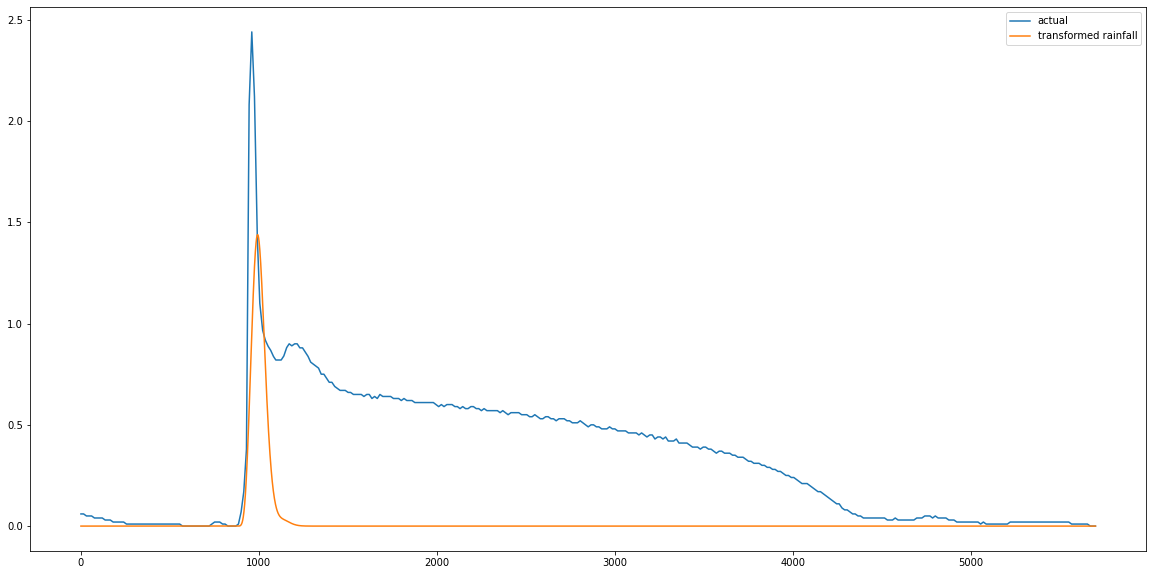

/usr/local/lib/python3.8/dist-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.8/dist-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


iteration no.
0

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper, bigger, smaller
[0.3075944202387723, 0.3296579547447814, 100, 0.3293442954277973, nan, 100, 0.3218279057479888, nan, 100, 2.8766440718428186, 0.3294158919487807]
speed
50
shape factors
[10]
scale factors
[10]
location factors
[0]
iteration no:
0



previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper, bigger, smaller
[0.3075944202387723, 0.3296529668569832, 100, 0.3246978094976517, nan, 100, 0.3169009694685, nan, 100, 1.5507574905242214, 0.32917382915278]
speed
10
shape factors
[10]
scale factors
[10]
location factors
[0]
iteration no:
1


shape up

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper, bigger, smaller
[0.3054516751447116, 0.3296579547447814, 0.3087455886308456, 0.3296579547447814, 0.3189953768177192, 100, 0.3054516751447116, nan, 0.305451675145972, 0.48081024200793404, 0.3272373267847744]
speed
2
shape

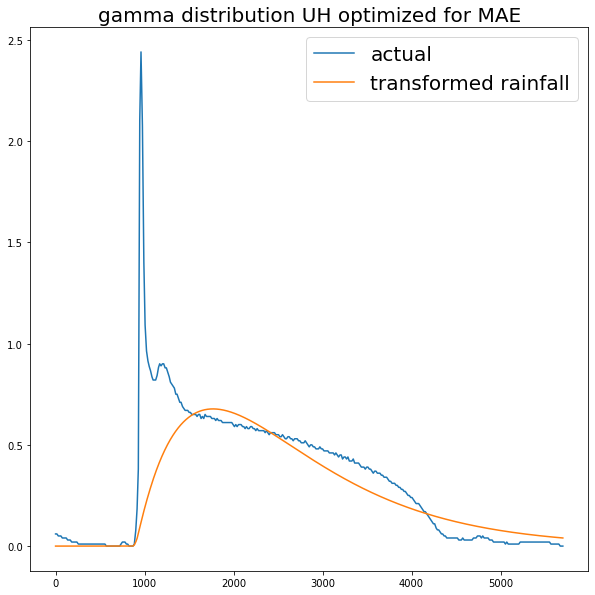

In [9]:
# mallets creek
#optimize_input_transformation(np.array(data.flow), np.array(data.rainfall), 1000)
# 800 through 1000 for peak fit
optimize_input_transformation(np.array(minutely.flow), np.array(minutely.rainfall), 5000)

# fitting functions

In [10]:
def SINDY_delays_3d(shape_factors, scale_factors, loc_factors, t, forcing, response, final_run, poly_degree):
  shape_time = np.arange(0,len(t),1) # analogous to drainage_time
  # shapes is analogous to "drainage" in original code
  feature_names=['response']# , 'forcing']
  shapes = np.zeros(shape=(len(t), len(shape_factors)))
  for shape_idx in range(0,len(shape_factors)):
    for idx in range(0,len(t)):
      if (abs(forcing[idx]) > 10**-6): # when nonzero forcing occurs
        if (idx == int(0)):

          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time, shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

        else:
          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time[:-idx], shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 


    feature_names.append(str("forcing" + str(shape_idx + 1)) )
  
  # SINDy
  model = ps.SINDy(
      differentiation_method= ps.SmoothedFiniteDifference(),
      feature_library=ps.PolynomialLibrary(degree=poly_degree,include_bias = False, include_interaction=False), 
      optimizer = ps.STLSQ(threshold=0), 
      feature_names = feature_names
  )

  #U = np.concatenate((np.reshape(forcing,(-1,1)), shapes) , axis=1)
  #if (any(shapes == np.inf)):
  #  print("infinite value in U")
  #U = np.nan_to_num(shapes,nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
  U = shapes
  model.fit(response,t=t,u=U)
  #model.print()
  #print("score = ",model.score(response,t=t,u=U)) # training data score

  mae = 10**6 # placeholder, shows simulation diverged or wasn't final run
  rmse = 10**6
  simulated = np.ones(shape=(len(response[1:]),1))*np.mean(response)
  if (final_run): 
    
    print("number of lines:")
    print(len(shape_factors))
    plt.figure(figsize=(20,10))
    plt.plot(U)
    plt.title("final input transformations")
    plt.show()
    '''
    plt.figure(figsize=(5,5))
    plt.title("input transformation parameters")
    plt.scatter(loc_factors, shape_factors)
    plt.xlabel("location")
    plt.ylabel("shape")
    plt.show()
    '''

    model.print(precision=5)
    print("score = ",model.score(response,t=t,u=U)) # training data score

    try: # in case simulation diverges
      y = np.reshape(response,(-1,1)) # to match simulation results dimension
      print(response.shape)
      print(type(response))
      print([response[1]])
      print(type([response[1]]))
      

      simulated = model.simulate([response[1]],t=t,u=U)

      fig, ax1 = plt.subplots(figsize=(20,10))
      ax2 = ax1.twinx()
      plt.title(str("polynomial degree = "+ str(poly_degree)))

      line1 = ax1.plot(t[1:],y[1:],'r-.',label='measurements')
      line2 = ax1.plot(t[1:],simulated[:len(t)-1],'g--',label='SINDy')
      ax1.set_xlabel(r'Time ($min$)')
      ax1.set_ylabel(r'response magnitude')
      ax1.set_ylim([1.2*min(y),1.2*max(y)])

      line3 = ax2.plot(t[1:],forcing[1:],'b',label='forcing')
      ax2.set_ylabel("forcing intensity")

      line4 = ax2.plot(t[1:], shapes[1:] * ( np.max(forcing) / np.max(shapes  ) ) , 'k--', label='transformed forcing (scaled)', alpha=0.35)
      
      lns = line1+line2+line3+line4
      labs = [l.get_label() for l in lns]
      plt.legend(lns, labs, loc=0,ncol=3)


      plt.show()
      
      mae = np.mean(np.abs(simulated[:len(t)-1]-y[1:])) # mean absolute error
      print("Simulation MAE = ", mae)
      rmse = np.sqrt(np.mean((simulated[:len(t)-1]-y[1:])**2)) # root mean squared error
      print("Simulation RMSE = ", rmse)


    except:
      print("Simulation diverged.")


    


  return [model.score(response,t=t,u=U), model, mae, rmse, t[1:], simulated[:len(t)-1] , response[1:] , forcing[1:] , U]

# takes np array X and assumes the zeroeth column is the forcing
def optimize_lag_shapes(polyorder, target, init_num_lines, max_num_lines, X,max_iter):
  # this is significantly modified to track the optimization, it's not as efficient as the normal version

  # tracking changes to input transformation for optimization figure
  track_shapes = list()
  track_scales = list()
  track_locations = list()
  track_scores = list()



  results = list()

  rates_of_change = abs(np.diff(X[:,target]))
  biggest_movers = np.flip(np.argsort(rates_of_change))
  maxes = np.array([biggest_movers[0]])
  if (maxes[0] < 1):
    maxes[0] = 1 # lower bound shape at 1

  # if a close neighbor is already selected, don't want that to be a starting point
  for index in range(0,len(biggest_movers)):
    if ( (abs(biggest_movers[index] - maxes) > int(len(X) / 1000*init_num_lines)).all()   ): 
      # more than some fraction of the total length apart
      # using init_num_lines strikes a balance between starting evenly spaced 
      # and starting all clustered on the steep regions
      if (biggest_movers[index] < 1):
        maxes = np.append(maxes,1) 
      else:
        maxes = np.append(maxes,float(biggest_movers[index]))
    if (len(maxes) >= max_num_lines):
      break

  previous_best = 0

  shape_factors = np.array([])
  scale_factors = np.array([])
  loc_factors = np.array([])
  speeds =  list([200,50,10,5,2, 1.1, 1.05, 1.01])
  
  for num_lines in range(init_num_lines,max_num_lines):
    #print(num_lines)
    #speed = 6.4 # how far we'll jump around initially
    speed_idx = 0
    speed = speeds[speed_idx]

    if (len(shape_factors) == 0):  # if we're starting right now
      # start sharp
      #loc_factors = maxes[0:init_num_lines]
      #scale_factors = np.ones(len(loc_factors))
      #shape_factors = np.ones(len(scale_factors))

      # start dull
      shape_factors = maxes[0:init_num_lines]
      scale_factors = np.ones(shape = shape_factors.shape)
      loc_factors = np.ones(shape = shape_factors.shape)

      
    else:
      # start dull
      sharp_cand = maxes[num_lines]
      delay_cand = 1
      loc_cand = 1

      # start sharp
      #delay_cand = 1
      #sharp_cand = 1
      #loc_cand = biggest_movers[-num_lines*3]
      shape_factors = np.append(shape_factors, sharp_cand)
      scale_factors = np.append(scale_factors, delay_cand)
      loc_factors = np.append(loc_factors, loc_cand)

    # changed prev model to true for verbose output
    prev_model = SINDY_delays_3d(shape_factors, scale_factors, loc_factors, np.arange(0,len(X)), X[:,0], X[:,target],False, polyorder )

    print("\nInitial model:\n")
    print("score")
    print(prev_model[0])
    print("shape factors")
    print(shape_factors)
    print("scale factors")
    print(scale_factors)
    print("location factors")
    print(loc_factors)
    print("")

    for iterations in range(0,max_iter ):
      track_scores.append(prev_model[0])
      track_shapes.append(shape_factors[0])
      track_scales.append(scale_factors[0])
      track_locations.append(loc_factors[0])

      tuning_line = iterations % num_lines

      sooner_locs = np.array(loc_factors)
      sooner_locs[tuning_line-1] = float(loc_factors[tuning_line-1] - speed*len(X)/10**4  )
      if ( sooner_locs[tuning_line-1] < 0):
        sooner = np.zeros(len(prev_model))
      else:
        sooner = SINDY_delays_3d(shape_factors ,scale_factors ,sooner_locs, 
          np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
        
      track_scores.append(sooner[0])
      track_shapes.append(shape_factors[0])
      track_scales.append(scale_factors[0])
      track_locations.append(sooner_locs[0])
      
      
      later_locs = np.array(loc_factors)
      later_locs[tuning_line-1] = float ( loc_factors[tuning_line-1]  +   1.01*speed*len(X)/10**4 )
      later = SINDY_delays_3d(shape_factors , scale_factors,later_locs, 
          np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      
      track_scores.append(later[0])
      track_shapes.append(shape_factors[0])
      track_scales.append(scale_factors[0])
      track_locations.append(later_locs[0])

      shape_up = np.array(shape_factors)
      shape_up[tuning_line-1] = float ( shape_factors[tuning_line-1]*speed*1.01 )
      shape_upped = SINDY_delays_3d(shape_up , scale_factors, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      

      track_scores.append(shape_upped[0])
      track_shapes.append(shape_up[0])
      track_scales.append(scale_factors[0])
      track_locations.append(loc_factors[0])
      
      shape_down = np.array(shape_factors)
      shape_down[tuning_line-1] = float ( shape_factors[tuning_line-1]/speed )
      if (shape_down[tuning_line-1] < 1):
        shape_downed = np.zeros(len(prev_model)) # return a score of zero as this is illegal
      else:
        shape_downed = SINDY_delays_3d(shape_down , scale_factors, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )


      track_scores.append(shape_downed[0])
      track_shapes.append(shape_down[0])
      track_scales.append(scale_factors[0])
      track_locations.append(loc_factors[0])

      scale_up = np.array(scale_factors)
      scale_up[tuning_line-1] = float(  scale_factors[tuning_line-1]*speed*1.01 )
      scaled_up = SINDY_delays_3d(shape_factors , scale_up, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )


      track_scores.append(scaled_up[0])
      track_shapes.append(shape_factors[0])
      track_scales.append(scale_up[0])
      track_locations.append(loc_factors[0])

      scale_down = np.array(scale_factors)
      scale_down[tuning_line-1] = float ( scale_factors[tuning_line-1]/speed )
      scaled_down = SINDY_delays_3d(shape_factors , scale_down, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      

      track_scores.append(scaled_down[0])
      track_shapes.append(shape_factors[0])
      track_scales.append(scale_down[0])
      track_locations.append(loc_factors[0])

      # rounder
      rounder_shape = np.array(shape_factors)
      rounder_shape[tuning_line-1] = shape_factors[tuning_line-1]*(speed*1.01)
      rounder_scale = np.array(scale_factors)
      rounder_scale[tuning_line-1] = scale_factors[tuning_line-1]/(speed*1.01)
      rounder = SINDY_delays_3d(rounder_shape , rounder_scale, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      

      track_scores.append(rounder[0])
      track_shapes.append(rounder_shape[0])
      track_scales.append(rounder_scale[0])
      track_locations.append(loc_factors[0])

      # sharper
      sharper_shape = np.array(shape_factors)
      sharper_shape[tuning_line-1] = shape_factors[tuning_line-1]/speed
      sharper_scale = np.array(scale_factors)
      sharper_scale[tuning_line-1] = scale_factors[tuning_line-1]*speed
      if (sharper_shape[tuning_line -1] < 1):
        sharper = np.zeros(len(prev_model)) # lower bound on shape to avoid inf
      else:
        sharper = SINDY_delays_3d(sharper_shape ,sharper_scale,loc_factors, 
                                  np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )


      track_scores.append(sharper[0])
      track_shapes.append(sharper_shape[0])
      track_scales.append(sharper_scale[0])
      track_locations.append(loc_factors[0])

      scores = [prev_model[0], shape_upped[0], shape_downed[0], scaled_up[0], scaled_down[0], sooner[0], later[0], rounder[0], sharper[0] ]
      #print(scores)
      if (sooner[0] >= max(scores)):
        prev_model = sooner
        loc_factors = sooner_locs
      elif (later[0] >= max(scores)):
        prev_model = later
        loc_factors = later_locs

      elif(shape_upped[0] >= max(scores)):
        prev_model = shape_upped
        shape_factors = shape_up
      elif(shape_downed[0] >=max(scores)):
        prev_model = shape_downed
        shape_factors = shape_down

      elif(scaled_up[0] >= max(scores)):
        prev_model = scaled_up
        scale_factors = scale_up
      elif(scaled_down[0] >= max(scores)):
        prev_model = scaled_down
        scale_factors = scale_down


      elif (rounder[0] >= max(scores)):
        prev_model = rounder
        shape_factors = np.array(rounder_shape)
        scale_factors = np.array(rounder_scale)
      elif (sharper[0] >= max(scores)):
        prev_model = sharper
        shape_factors = np.array(sharper_shape)
        scale_factors = np.array(sharper_scale)


      elif( (num_lines - 1) == tuning_line): # the middle was best, but it's bad, tighten up the bounds (if we're at the last tuning line)
        
        speed_idx = speed_idx + 1
        
        if (speed_idx >= len(speeds)):
          break
        speed = speeds[speed_idx]
        
        '''
        if (speed > 10):
          speed = speed*0.5 # coarse tuning
          
        elif(speed > 1.3):
          speed = speed*0.8 # fine tuning
        else:
          speed = speed*0.95 # very fine tuning
        '''
        print("\nprevious, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper")
        
        print(scores)
        track_scores.append(scores[0])
        print(len(track_scores))
        print("speed")
        print(speed)
        print("shape factors")
        print(shape_factors)
        track_shapes.append(shape_factors[0])
        print("scale factors")
        print(scale_factors)
        track_scales.append(scale_factors[0])
        print("location factors")
        print(loc_factors)
        track_locations.append(loc_factors[0])
        print("iteration no:")
        print(iterations)
        print("\n")
        
        #print(scores)
        if (speed < 1):
          print("converged, max accuracy for number of lines")
          break
    
    
    final_model = SINDY_delays_3d(shape_factors, scale_factors ,loc_factors,np.arange(0,len(X)), X[:,0], X[:,target], True, polyorder )
    results.append([final_model, shape_factors, scale_factors, loc_factors])
    if ((previous_best and final_model[0] - previous_best[0] < 0.005) or ( previous_best and final_model[0] - previous_best[0] < 0.01 and final_model[2] > previous_best[2] )): 
      # marginal (less than half percent improvement) OR somewhat marginal improvement in fit and worse mae
      break # we can be done
    else:
      previous_best = final_model
  winning_model = None
  best_mae = np.Inf
  for num_lines in range(len(results)):
    if (results[num_lines][0][2] < best_mae):
      winning_model = results[num_lines]
      best_mae = results[num_lines][0][2]

  return [winning_model, track_shapes, track_scales, track_locations, track_scores]
    
def transform_input(shape_factors, scale_factors, loc_factors,t, forcing):
  shape_time = np.arange(0,len(t),1) # analogous to drainage_time
  # shapes is analogous to "drainage" in original code
  feature_names=['response']# , 'forcing']
  shapes = np.zeros(shape=(len(t), len(shape_factors)))
  for shape_idx in range(0,len(shape_factors)):
    for idx in range(0,len(t)):
      if (abs(forcing[idx]) > 10**-6): # when nonzero forcing occurs
        if (idx == int(0)):

          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time, shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

        else:
          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time[:-idx], shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

  return shapes 


# fitting with various orders of model

In [11]:
X = np.concatenate((np.reshape(np.array(minutely.rainfall),(-1,1)),np.reshape(np.array(minutely.flow) , (-1,1) )),axis=1)
#a = optimize_lag_shapes(1,1,1,6,X,1000)

In [12]:
#b = optimize_lag_shapes(2,1,1,6,X,1000)

In [13]:
#c = optimize_lag_shapes(3,1,1,6,X,1000)

In [14]:
#d = optimize_lag_shapes(4,1,1,6,X,1000)


Initial model:

score
3.1696534420366795e-05
shape factors
[941.]
scale factors
[1.]
location factors
[1.]


previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.17740902255976443, 5.4453643552609954e-05, 0.0, 0.01052535375546726, 7.299161168594637e-06, 0.0, 0.03747554290134836, 0.05565669264542672, 0.0]
19
speed
50
shape factors
[4.705]
scale factors
[1.]
location factors
[1.]
iteration no:
1



previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.1896039015124824, 7.299161168594637e-06, 0.0, 0.005947336718129637, 0.17993144002288597, 0.0, 0.08814526443521509, 0.0007106798928918634, 0.0]
38
speed
10
shape factors
[4.705]
scale factors
[50.5]
location factors
[1.]
iteration no:
3



previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.8328032027594126, 0.001895178802473696, 0.0, 0.18178128602937393, 0.09502336899788055, 0.6487991425142481, 0.6546537311165879, 0.3704680376771945,

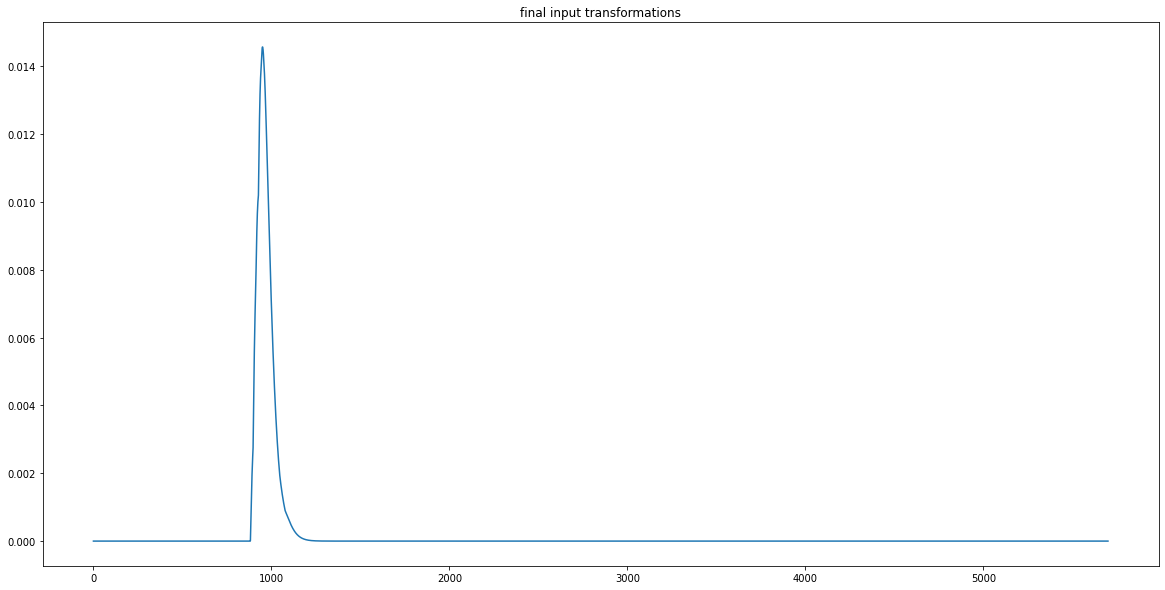

(response)' = -0.00340 response + -4.57890 forcing1 + 0.00421 response^2 + 5534.12057 forcing1^2 + 0.01824 response^3 + -1633232.35818 forcing1^3 + -0.03091 response^4 + 167285288.18469 forcing1^4 + 0.00762 response^5 + -5229795557.13115 forcing1^5
score =  0.940325139707545
(5701,)
<class 'numpy.ndarray'>
[0.05999999999999961]
<class 'list'>


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


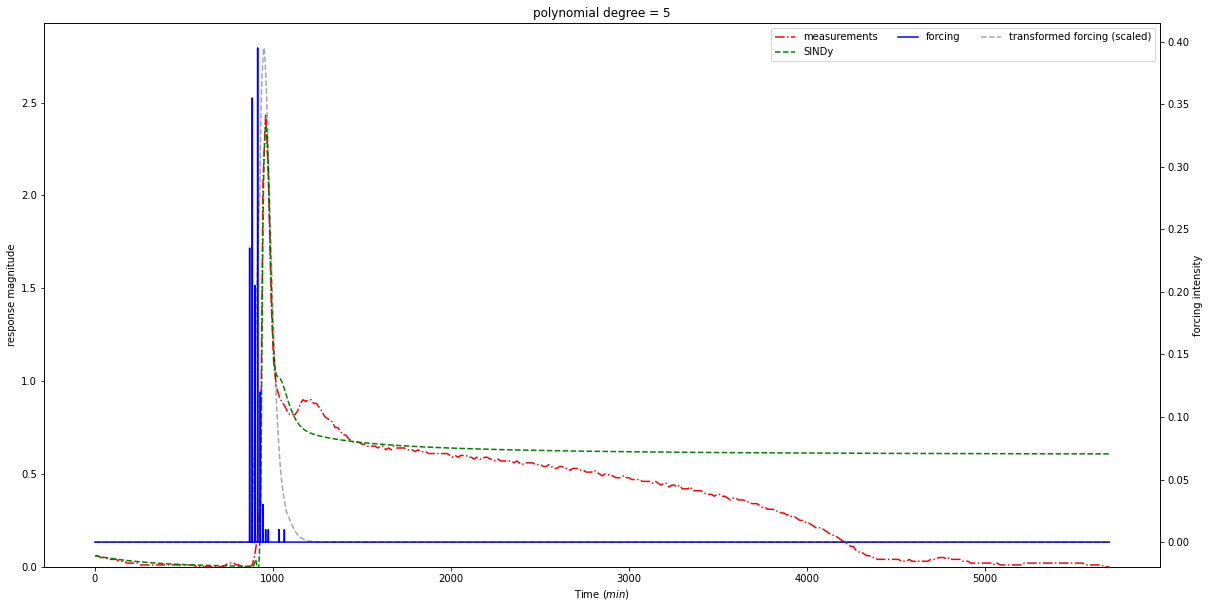

Simulation MAE =  0.2350779199946077
Simulation RMSE =  0.32788428007984416

Initial model:

score
0.9403412933134517
shape factors
[  2.13863636 985.        ]
scale factors
[24.9332842  1.       ]
location factors
[11.88891  1.     ]


previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.9419891373314662, 0.18657046832258306, 0.0, 0.19276444424872297, 0.24564954237974324, 0.0, 0.1906906976793299, 0.2610879439598266, 0.0]
224
speed
50
shape factors
[2.13863636 4.925     ]
scale factors
[24.9332842  1.       ]
location factors
[11.88891  1.     ]
iteration no:
1



previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.9480510424137548, 0.0029660374014714996, 0.0, 0.014902755121281475, 0.07511124175040429, 0.0, 0.529402627519183, 0.46428095014379345, 0.0]
243
speed
10
shape factors
[  2.13863636 248.7125    ]
scale factors
[24.9332842  1.       ]
location factors
[11.88891  1.     ]
iteration no:
3



previous, shape 

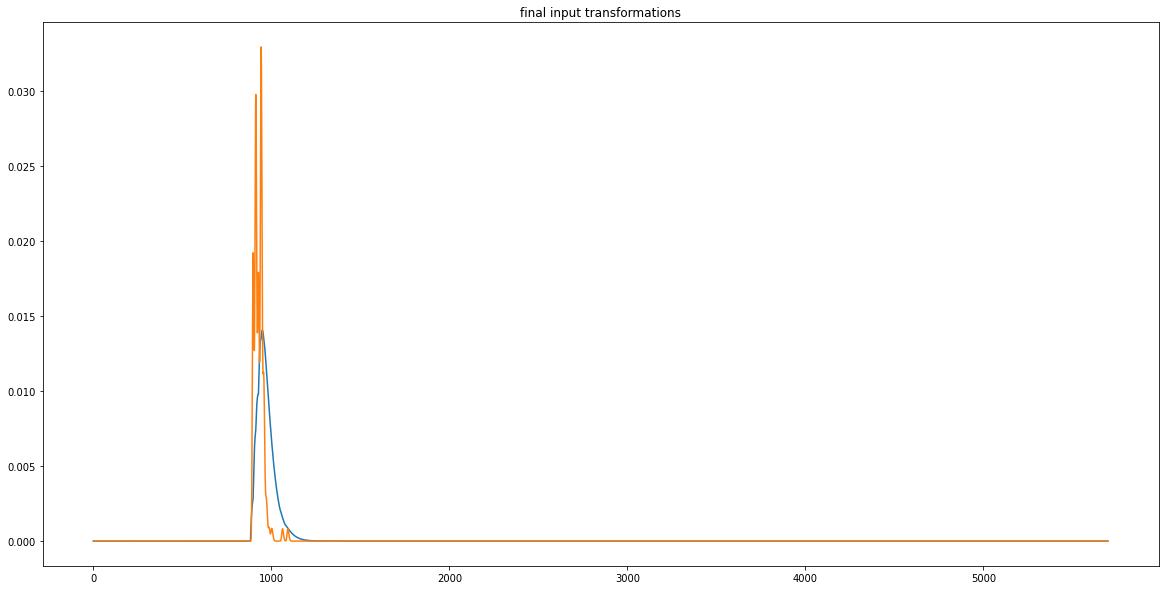

(response)' = -0.00301 response + -6.33664 forcing1 + 0.27360 forcing2 + -0.00064 response^2 + 6288.07368 forcing1^2 + 464.26662 forcing2^2 + 0.02620 response^3 + -1890218.00116 forcing1^3 + -56110.72322 forcing2^3 + -0.03227 response^4 + 199155196.88588 forcing1^4 + 2204228.31937 forcing2^4 + 0.00754 response^5 + -6488451281.62515 forcing1^5 + -27355528.52694 forcing2^5
score =  0.9659530555944197
(5701,)
<class 'numpy.ndarray'>
[0.05999999999999961]
<class 'list'>


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


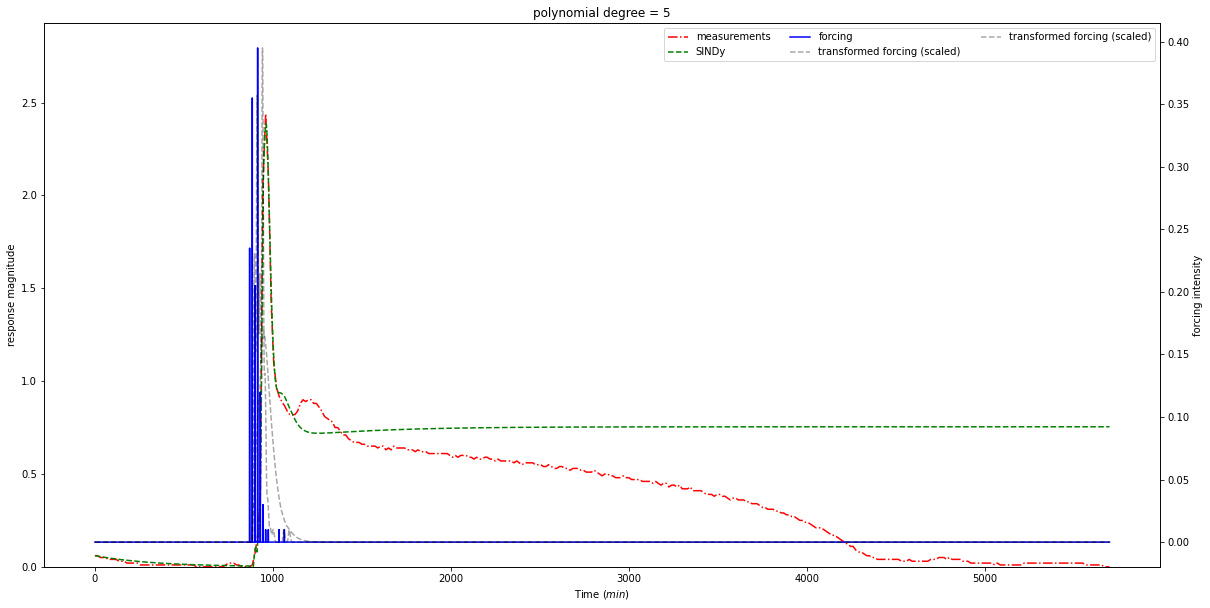

Simulation MAE =  0.3299374006400766
Simulation RMSE =  0.4286170955862901

Initial model:

score
0.9659861865299998
shape factors
[  1.83330021  24.89517496 977.        ]
scale factors
[29.67054973  0.9891475   1.        ]
location factors
[12.5222911  3.879005   1.       ]


previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.9683973961390583, 0.9404817734087224, 0.0, 0.940522286916901, 0.9433587736614923, 0.0, 0.9458681326316807, 0.9484105036252127, 0.0]
474
speed
50
shape factors
[ 1.83330021 24.89517496  4.885     ]
scale factors
[29.67054973  0.9891475   1.        ]
location factors
[12.5222911  3.879005   1.       ]
iteration no:
2



previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.9719609642450221, 0.9446510811262989, 0.0, 0.9447345410021024, 0.9448032342938499, 0.0, 0.9712260273023244, 0.9570056854018549, 0.0]
502
speed
10
shape factors
[ 1.83330021 24.89517496  4.885     ]
scale factors
[29.67054973

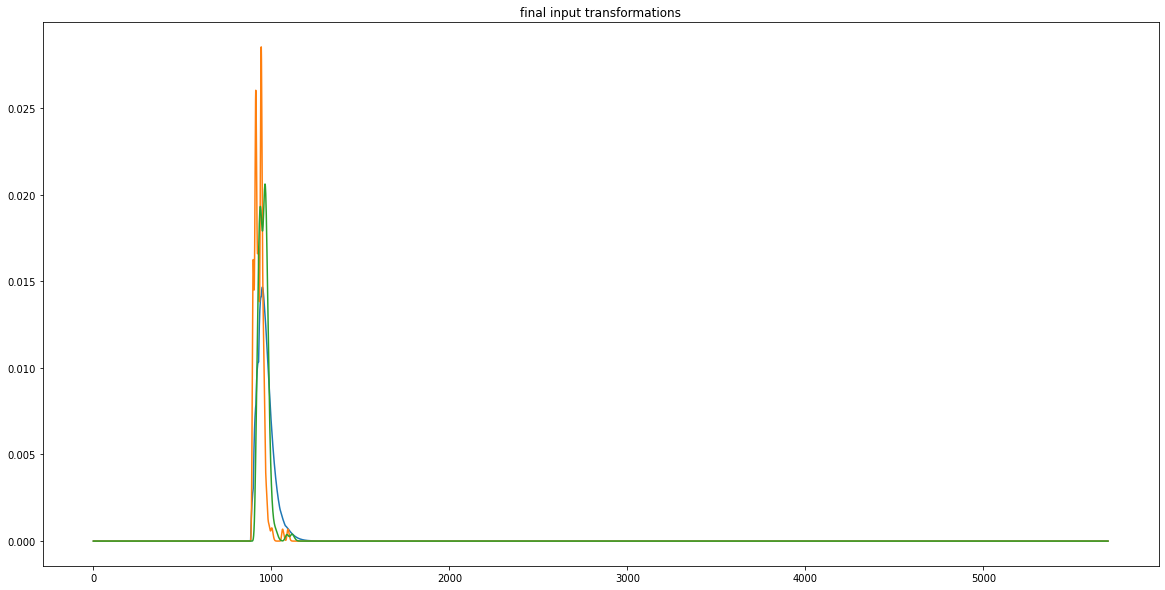

(response)' = -0.00037 response + -0.58835 forcing1 + -2.18675 forcing2 + -1.99044 forcing3 + -0.01157 response^2 + 2093.87600 forcing1^2 + 809.72551 forcing2^2 + -891.41618 forcing3^2 + 0.03906 response^3 + -1078085.44645 forcing1^3 + -73795.83565 forcing2^3 + -55510.62899 forcing3^3 + -0.03697 response^4 + 161730729.06222 forcing1^4 + 2498735.01865 forcing2^4 + 10992796.18761 forcing3^4 + 0.00818 response^5 + -6320339924.95697 forcing1^5 + -26398077.96568 forcing2^5 + -337204760.24751 forcing3^5
score =  0.9861681760611345
(5701,)
<class 'numpy.ndarray'>
[0.05999999999999961]
<class 'list'>


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


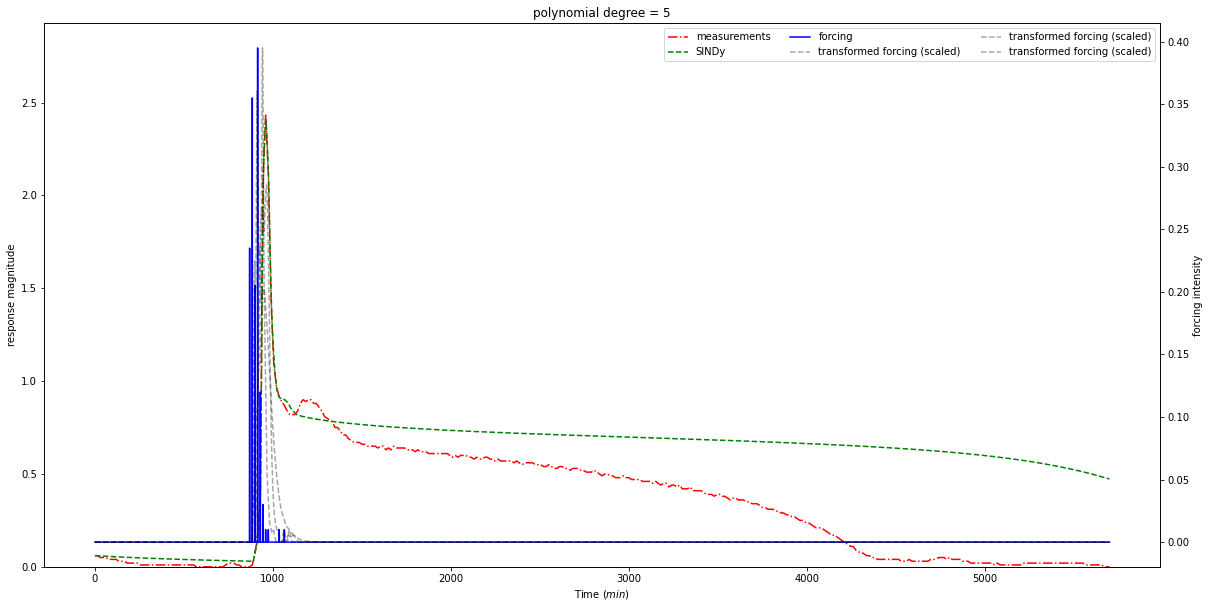

Simulation MAE =  0.26675778951988327
Simulation RMSE =  0.33792381590826753

Initial model:

score
0.9861911433433928
shape factors
[  1.90773955  17.62012093  19.5852091  953.        ]
scale factors
[26.86036161  1.4115255   2.44508301  1.        ]
location factors
[13.1556722  4.5123861  6.75801    1.       ]


previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.9866845078279829, 0.9643875922777861, 0.0, 0.96447362762709, 0.9654396802821403, 0.0, 0.9657426419316631, 0.9653148516346612, 0.0]
1084
speed
50
shape factors
[ 1.90773955 17.62012093 19.5852091   4.765     ]
scale factors
[ 26.86036161   1.4115255    2.44508301 200.        ]
location factors
[13.1556722  4.5123861  6.75801    1.       ]
iteration no:
3



previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.9866934129062037, 0.964627058321932, 0.0, 0.9676814176258239, 0.9657151069871152, 0.0, 0.9685323936036804, 0.9655123689955375, 0.0]
1121
speed
10
s

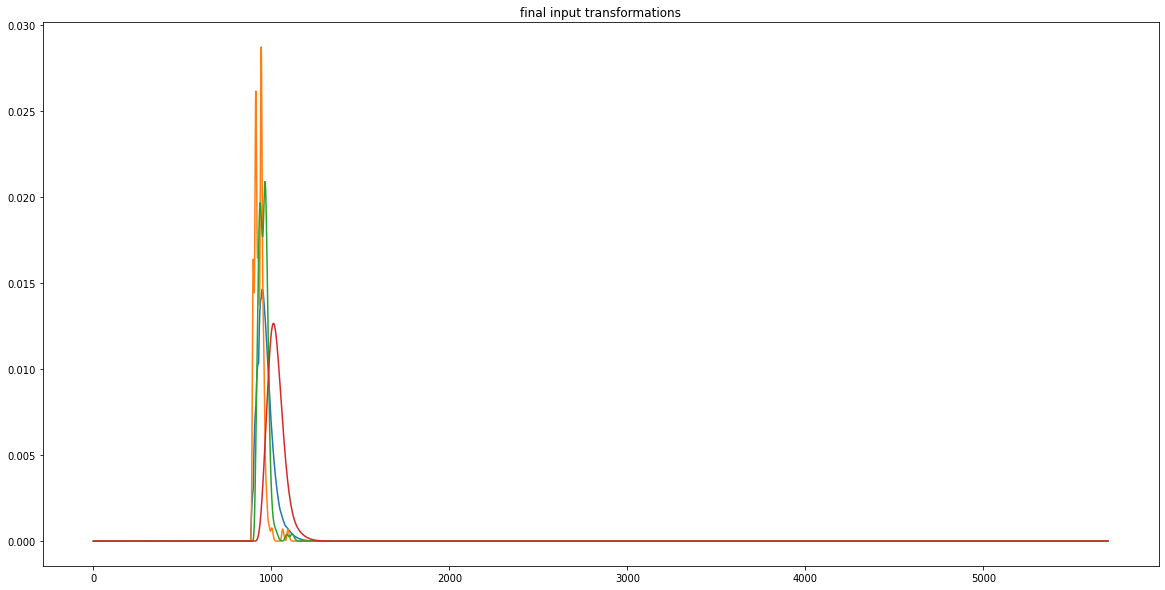

(response)' = -0.00292 response + 0.60144 forcing1 + -4.30894 forcing2 + -17.90589 forcing3 + 6.82803 forcing4 + 0.00238 response^2 + 6102.05743 forcing1^2 + 644.64895 forcing2^2 + 2836.38062 forcing3^2 + -2346.29537 forcing4^2 + 0.01854 response^3 + -1966741.70078 forcing1^3 + -48780.90731 forcing2^3 + -420306.38180 forcing3^3 + 250664.73536 forcing4^3 + -0.02955 response^4 + 233075503.07737 forcing1^4 + 1646661.31042 forcing2^4 + 26852743.62603 forcing3^4 + -11469545.94123 forcing4^4 + 0.00770 response^5 + -8292885731.84751 forcing1^5 + -17954387.60498 forcing2^5 + -591070795.51029 forcing3^5 + 187111106.42981 forcing4^5
score =  0.9906195527250575
(5701,)
<class 'numpy.ndarray'>
[0.05999999999999961]
<class 'list'>


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


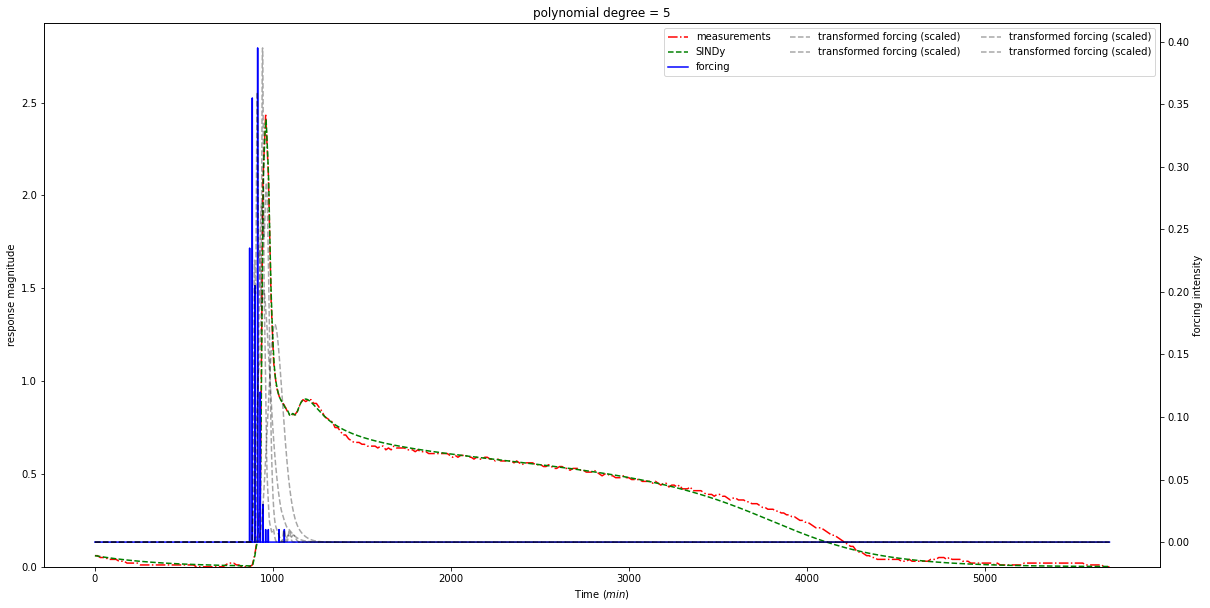

Simulation MAE =  0.01604559662121665
Simulation RMSE =  0.024089728717288768


In [15]:
e = optimize_lag_shapes(5,1,1,6,X,1000)

# background summary figure v1 (all-in-one)

In [16]:
model = ps.SINDy(
    differentiation_method= ps.SmoothedFiniteDifference(),
    feature_library=ps.PolynomialLibrary(degree=5,include_bias = True, include_interaction=True), 
    optimizer = ps.STLSQ(threshold=0), 
    feature_names = ['Discharge','Rainfall']
)
model.fit(e[0][0][-4],t=e[0][0][-5],u=e[0][0][-2])

simulated = model.simulate(e[0][0][-4][0],t=e[0][0][-5],u=np.reshape(e[0][0][-2], (-1,1) )  )
simulated = np.insert(simulated,0,e[0][0][-4][0])

/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


(Discharge)' = -0.00002 1 + -0.00029 Discharge + -1.82012 Rainfall + -0.00028 Discharge^2 + 2.05020 Discharge Rainfall + 12.07134 Rainfall^2 + 0.00335 Discharge^3 + 4.42995 Discharge^2 Rainfall + 3.54100 Discharge Rainfall^2 + -16.84004 Rainfall^3 + -0.00395 Discharge^4 + -7.76195 Discharge^3 Rainfall + -25.89462 Discharge^2 Rainfall^2 + -6.58421 Discharge Rainfall^3 + -7.20840 Rainfall^4 + 0.00111 Discharge^5 + 2.20893 Discharge^4 Rainfall + 53.90681 Discharge^3 Rainfall^2 + -10.33702 Discharge^2 Rainfall^3 + -7.22411 Discharge Rainfall^4 + -1.70762 Rainfall^5
score =  0.04500151387760187


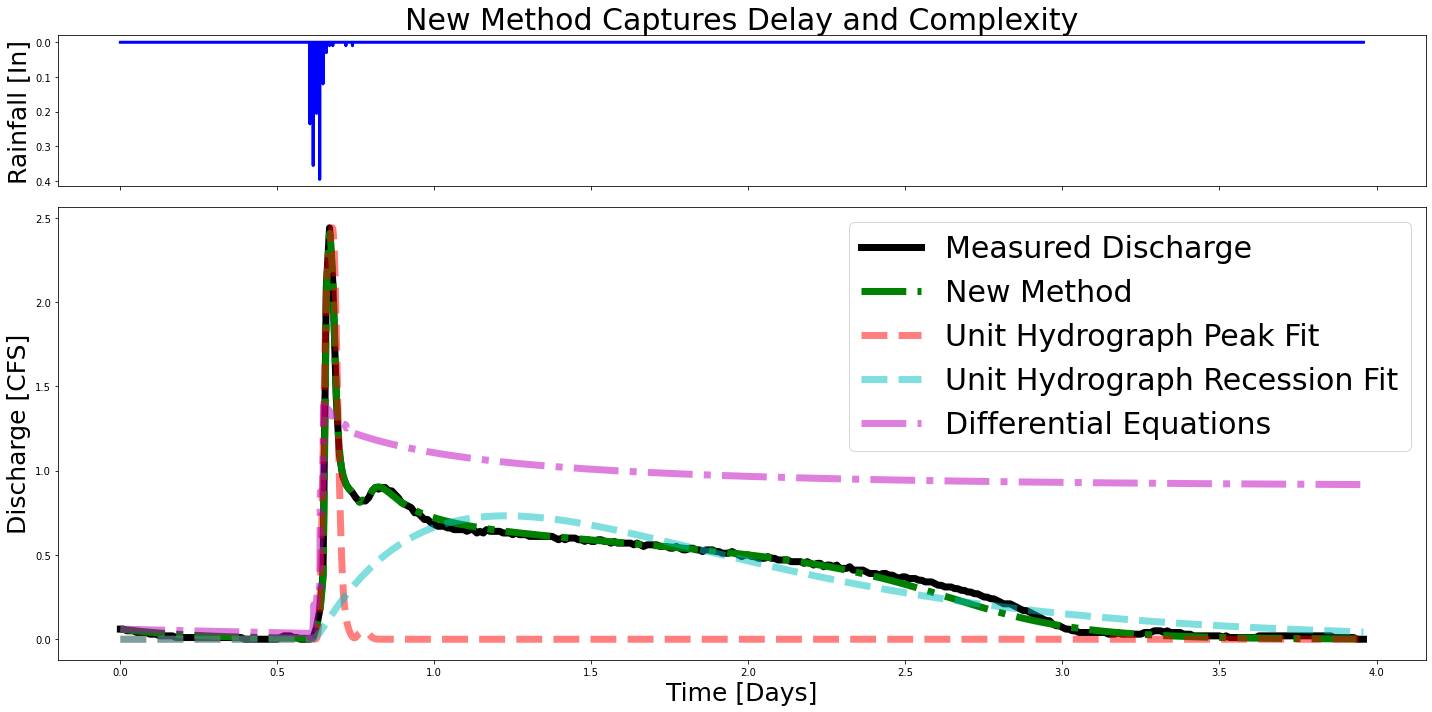

In [17]:
# rainfall transformation to fit peak
# shape = 23 , scale = 3 , location = 0
# to fit recession curve
# shape 2 scale 866 location 0

# then plot one of the above (fourth order) 
# label it as "model discovery with rainfall transformations"

# then run vanilla sindy and include that

#print(e[0])
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(20,10),sharex=True,gridspec_kw={'height_ratios': [1, 3]} )

l1 = ax[1].plot(e[0][0][-5]/60/24,e[0][0][-3],'k-', label='Measured Discharge',alpha=1,linewidth=7) # measurements
l2 = ax[1].plot(e[0][0][-5]/60/24,e[0][0][-4],'g-.', label='New Method',alpha=1,linewidth=7) # model fit


#ax[0].set_ylim([0,10*max(e[0][0][-2])])
ax[0].invert_yaxis()
l3 = ax[0].plot(e[0][0][-5]/60/24,e[0][0][-2],'b',label='Rainfall',alpha=1,linewidth=3) # rainfall


#def transform_input(shape_factors, scale_factors, loc_factors,t, forcing)
peak_fit = transform_input([23],[3],[0],e[0][0][-5], e[0][0][-2])
l4 = ax[1].plot(e[0][0][-5]/60/24, max(e[0][0][-3]) / max(peak_fit) * peak_fit, 'r--', label = 'Unit Hydrograph Peak Fit',alpha=0.5,linewidth=7)
recession_fit = transform_input([2],[866],[0],e[0][0][-5], e[0][0][-2])
l5 = ax[1].plot(e[0][0][-5]/60/24, 0.3*max(e[0][0][-3]) / max(recession_fit) * recession_fit,'c--', label='Unit Hydrograph Recession Fit',alpha=0.5,linewidth=7)



model.print(precision=5)
print("score = ",model.score(e[0][0][-4],t=e[0][0][-5],u=e[0][0][-2])) # training data score

l6 = ax[1].plot(e[0][0][-5]/60/24, simulated, 'm-.',label='Differential Equations',alpha=0.5,linewidth=7)

lns = l1+l2+l4+l5+l6
labs = [l.get_label() for l in lns]
ax[1].legend(lns, labs, loc=0, fontsize=30)
ax[1].set_xlabel("Time [Days]",fontsize=25)
ax[1].set_ylabel("Discharge [CFS]",fontsize=25)
ax[0].set_ylabel("Rainfall [In]",fontsize=25)
ax[0].set_title("New Method Captures Delay and Complexity",fontsize=30)
plt.tight_layout()


# figure 1 v2 (separated)

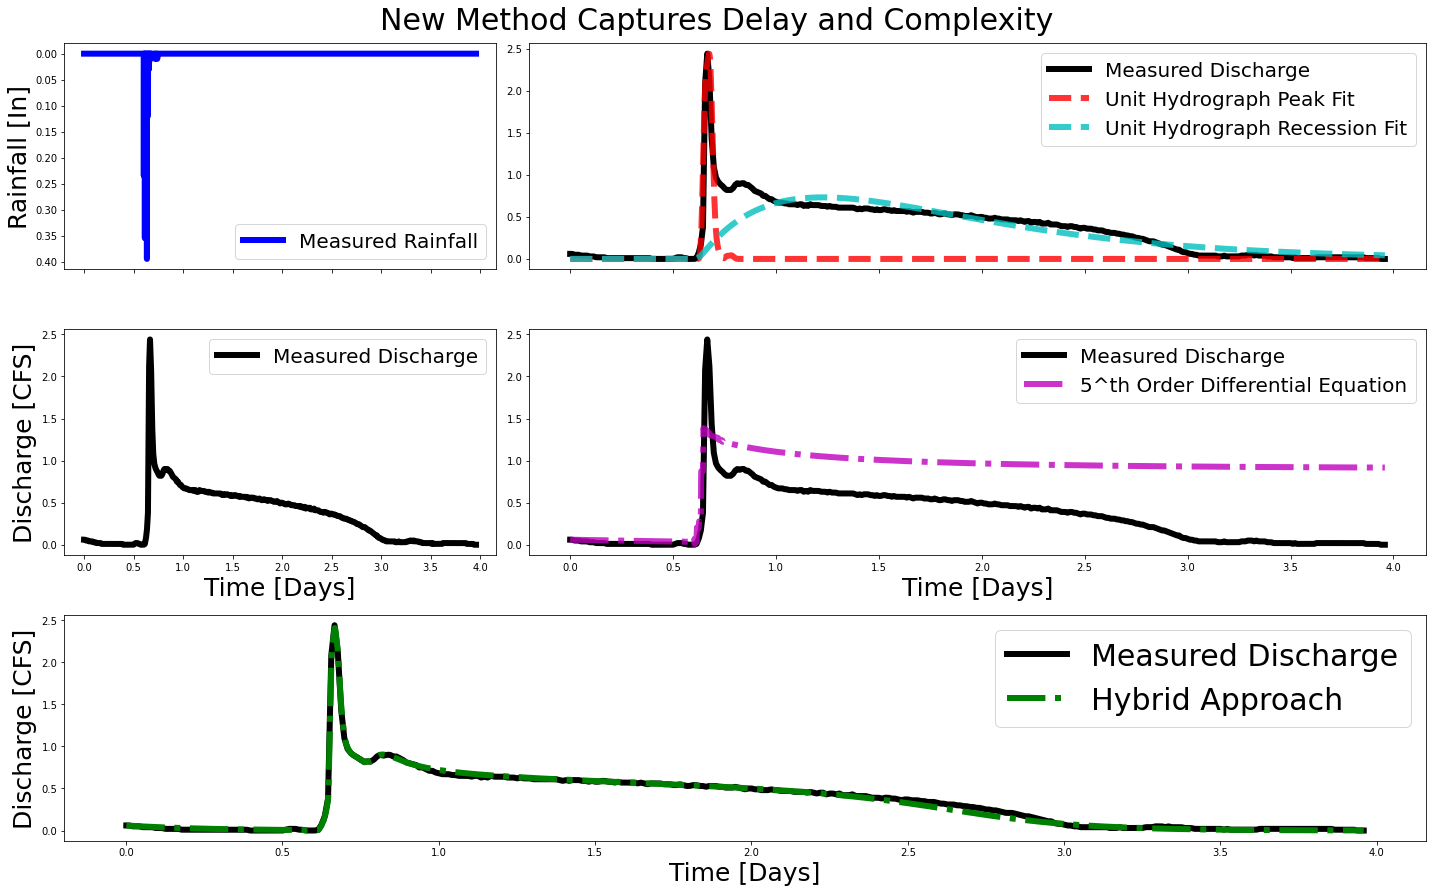

In [18]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(20,12))

gs = GridSpec(3,3,figure=fig)
rain_ax = fig.add_subplot(gs[0,0])
rain_ax.plot(e[0][0][-5]/60/24,e[0][0][-2],'b',label='Measured Rainfall',alpha=1,linewidth=6)

rain_ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=True,
    left=True) # labels along the bottom edge are off
rain_ax.set_ylabel("Rainfall [In]",fontsize=25)
rain_ax.invert_yaxis()
rain_ax.legend(fontsize=20)

real_discharge_ax = fig.add_subplot(gs[1,0])
real_discharge_ax.plot(e[0][0][-5]/60/24,e[0][0][-3],'k-', label='Measured Discharge',alpha=1,linewidth=6)
real_discharge_ax.set_ylabel("Discharge [CFS]",fontsize=25)
real_discharge_ax.set_xlabel("Time [Days]",fontsize=25)
real_discharge_ax.legend(fontsize=20)

uh_ax = fig.add_subplot(gs[0,1:])
uh_ax.tick_params(
    axis='x',
    labelbottom=False
)
uh_ax.plot(e[0][0][-5]/60/24,e[0][0][-3],'k-', label='Measured Discharge',alpha=1,linewidth=6)
uh_ax.plot(e[0][0][-5]/60/24, max(e[0][0][-3]) / max(peak_fit) * peak_fit, 'r--', label = 'Unit Hydrograph Peak Fit',alpha=0.8,linewidth=6)
uh_ax.plot(e[0][0][-5]/60/24, 0.3*max(e[0][0][-3]) / max(recession_fit) * recession_fit,'c--', label='Unit Hydrograph Recession Fit',alpha=0.8,linewidth=6)
uh_ax.legend(fontsize=20)

diffeq_ax = fig.add_subplot(gs[1,1:])
diffeq_ax.set_xlabel("Time [Days]",fontsize=25)
diffeq_ax.plot(e[0][0][-5]/60/24,e[0][0][-3],'k-', label='Measured Discharge',alpha=1,linewidth=6)
diffeq_ax.plot(e[0][0][-5]/60/24, simulated, 'm-.',label=r"5^th Order Differential Equation",alpha=0.8,linewidth=6)
diffeq_ax.legend(fontsize=20)

new_ax = fig.add_subplot(gs[2,:])
new_ax.plot(e[0][0][-5]/60/24,e[0][0][-3],'k-', label='Measured Discharge',alpha=1,linewidth=6)
new_ax.plot(e[0][0][-5]/60/24,e[0][0][-4],'g-.', label='Hybrid Approach',alpha=1,linewidth=6)
new_ax.set_xlabel("Time [Days]",fontsize=25)
new_ax.set_ylabel("Discharge [CFS]",fontsize=25)
new_ax.legend(fontsize=30)

fig.suptitle("New Method Captures Delay and Complexity",fontsize=30,y=1.03)
plt.tight_layout()

# figure 1 v3

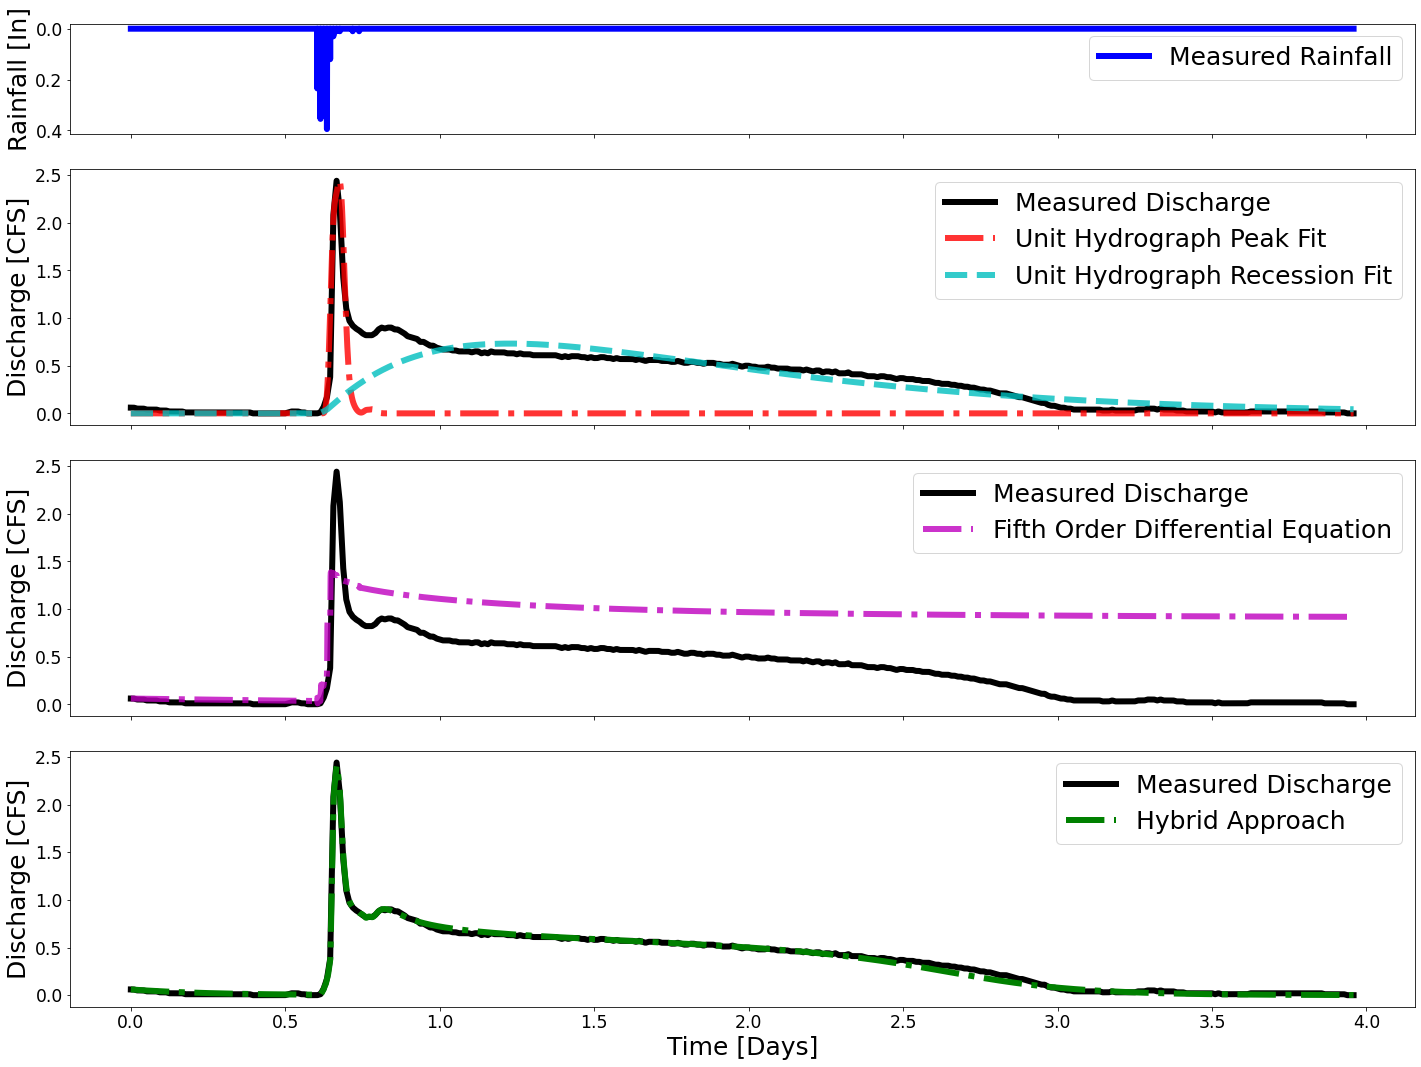

In [19]:

fig = plt.figure(figsize=(20,15))

gs = GridSpec(7,2,figure=fig)
rain_ax = fig.add_subplot(gs[0,:])
rain_ax.plot(e[0][0][-5]/60/24,e[0][0][-2],'b',label='Measured Rainfall',alpha=1,linewidth=6)

rain_ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=True,
    left=True
    ) # labels along the bottom edge are off
rain_ax.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize='xx-large'
    ) # labels along the bottom edge are off

rain_ax.set_ylabel("Rainfall [In]",fontsize=25)
rain_ax.invert_yaxis()
rain_ax.legend(fontsize=25)
'''
real_discharge_ax = fig.add_subplot(gs[1,:])
real_discharge_ax.plot(e[0][0][-5]/60/24,e[0][0][-3],'k-', label='Measured Discharge',alpha=1,linewidth=6)
real_discharge_ax.set_ylabel("Discharge [CFS]",fontsize=25)
real_discharge_ax.set_xlabel("Time [Days]",fontsize=25)
real_discharge_ax.legend(fontsize=20)
'''
uh_ax = fig.add_subplot(gs[1:3,:])
uh_ax.tick_params(
    axis='x',
    labelbottom=False,
    which = 'both'
)
uh_ax.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize='xx-large'
    ) # labels along the bottom edge are off
uh_ax.plot(e[0][0][-5]/60/24,e[0][0][-3],'k-', label='Measured Discharge',alpha=1,linewidth=6)
uh_ax.plot(e[0][0][-5]/60/24, max(e[0][0][-3]) / max(peak_fit) * peak_fit, 'r-.', label = 'Unit Hydrograph Peak Fit',alpha=0.8,linewidth=6)
uh_ax.plot(e[0][0][-5]/60/24, 0.3*max(e[0][0][-3]) / max(recession_fit) * recession_fit,'c--', label='Unit Hydrograph Recession Fit',alpha=0.8,linewidth=6)
uh_ax.set_ylabel("Discharge [CFS]",fontsize=25)
uh_ax.legend(fontsize=25)

diffeq_ax = fig.add_subplot(gs[3:5,:])
#diffeq_ax.set_xlabel("Time [Days]",fontsize=25)
diffeq_ax.tick_params(
    axis='x',
    labelbottom=False,
    which='both'
)
diffeq_ax.tick_params(
    axis='y',          # changes apply to the x-axis
    labelsize='xx-large'
    ) # labels along the bottom edge are off
diffeq_ax.plot(e[0][0][-5]/60/24,e[0][0][-3],'k-', label='Measured Discharge',alpha=1,linewidth=6)
diffeq_ax.plot(e[0][0][-5]/60/24, simulated, 'm-.',label="Fifth Order Differential Equation",alpha=0.8,linewidth=6)
diffeq_ax.set_ylabel("Discharge [CFS]",fontsize=25)
diffeq_ax.legend(fontsize=25)


new_ax = fig.add_subplot(gs[5:7,:])
new_ax.plot(e[0][0][-5]/60/24,e[0][0][-3],'k-', label='Measured Discharge',alpha=1,linewidth=6)
new_ax.plot(e[0][0][-5]/60/24,e[0][0][-4],'g-.', label='Hybrid Approach',alpha=1,linewidth=6)
new_ax.set_xlabel("Time [Days]",fontsize=25)
new_ax.set_ylabel("Discharge [CFS]",fontsize=25)
new_ax.legend(fontsize=25)
new_ax.tick_params(
    axis='both',          # changes apply to the x-axis
    labelsize='xx-large'
    ) 

#fig.suptitle("Hybrid Approach Captures Delay and Complexity",fontsize=30,y=1.01)
plt.tight_layout()
plt.savefig(fname='/content/drive/MyDrive/PhD Admin and Notes/paper1/figure1.svg',bbox_inches='tight',transparent=True)
plt.savefig(fname='/content/drive/MyDrive/PhD Admin and Notes/paper1/figure1.png',bbox_inches='tight',transparent=True)
